# Libraries

## Install

## Import

In [114]:
# import urllib library

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
from tqdm.notebook import tqdm as tqdm
from isoweek import Week
import seaborn as sns
import wbgapi as wb
import country_converter as coco
import time
from datetime import date
from datetime import datetime
import plotly.graph_objs as go
import os

import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px

In [2]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

#Changing dir
folder = 'DATA'
try:
    os.chdir(f'{os.getcwd()}/{folder}')
except:
    dir = os.getcwd().replace(os.getcwd().split('/')[-1], folder)
    os.chdir(dir)
    
print(f'New directory: {dir}')

New directory: /Users/gustavo/Library/CloudStorage/OneDrive-Pessoal/Msc Data Analitics/Git_CA2/DATA


# Project

## Timeline

Creating timeline as requested in the assessment. Tuturial available in [Splunktool](https://splunktool.com/timeline-in-python)

In [3]:
#Creating the dates and labels
'''
28/11/22 - Assessment available
30/11/22 - Researching the subject
04/12/22 - Theme definition
05/12/22 - Research on the Theme
06/12/22 - Definition of approach and KIPs
08/12/22 - Searching Database available
10/12/22 - EDA
25/12/22 - Creating KPIs and visualizations
28/12/22 - ML (Sentimental analysis)
01/01/23 - Writing report
06/01/23 - Assessment submission
'''

dates = [date(2022, 11, 28), date(2022, 11, 30), date(2022, 12, 4), date(2022, 12, 5),
         date(2022, 12, 10), date(2022, 12, 25),
         date(2022, 12, 28), date(2023, 1, 1), date(2023, 1, 6)]
min_date = date(np.min(dates).year, np.min(dates).month, np.min(dates).day - 2)
max_date = date(np.max(dates).year, np.max(dates).month, np.max(dates).day + 2)
 
labels = ['Assessment\navailable', 'Researching the\nsubject', 'Theme\ndefinition', 
          'Research on\nthe Theme', 'Searching Database\navailable and EDA',
          'Creating KPIs and\nvisualizations', 'ML\n(Sentimental analysis)', 'Writing\nreport', 'Assessment\nsubmission']
# labels with associated dates
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]

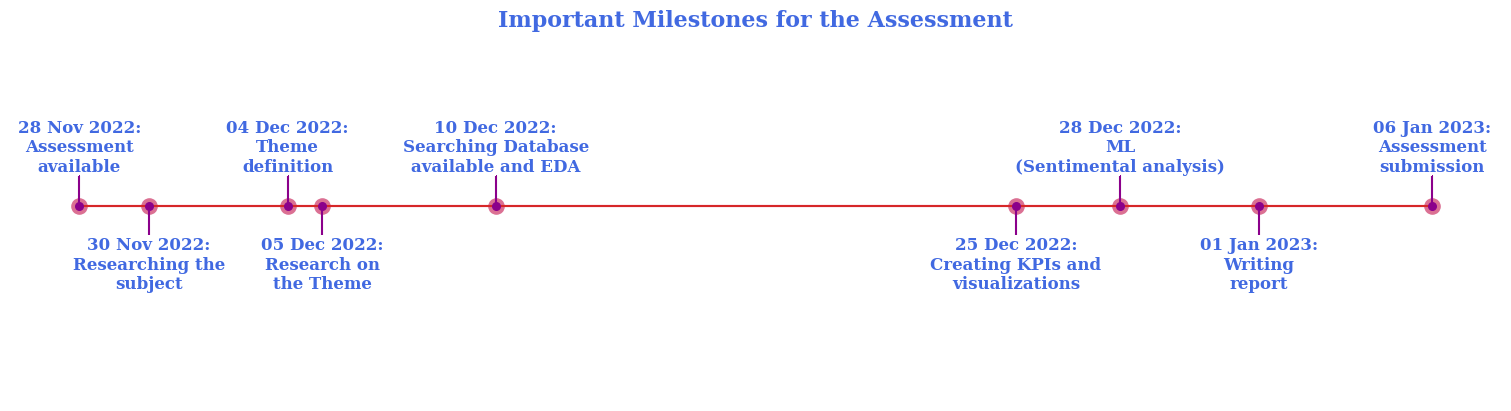

In [4]:
#Plotting

%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)
_ = ax.set_ylim(-2, 1.75)
_ = ax.set_xlim(min_date, max_date)
_ = ax.axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)
 
_ = ax.scatter(dates, np.zeros(len(dates)), s=120, c='palevioletred', zorder=2)
_ = ax.scatter(dates, np.zeros(len(dates)), s=30, c='darkmagenta', zorder=3)

label_offsets = np.zeros(len(dates))
label_offsets[::2] = 0.35
label_offsets[1::2] = -0.85
for i, (l, d) in enumerate(zip(labels, dates)):
    _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=12)

stems = np.zeros(len(dates))
stems[::2] = 0.3
stems[1::2] = -0.3   
markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
_ = plt.setp(markerline, marker=',', color='darkmagenta')
_ = plt.setp(stemline, color='darkmagenta')


# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)
     # hide tick labels
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
 
    _ = ax.set_title('Important Milestones for the Assessment', fontweight="bold", fontfamily='serif', fontsize=16, 
                 color='royalblue')

The timeline above is demonstring the schedule for this project.

# Data

Agri-Food

Looking into European Commission Portal, there is the [Agri-food Portal](https://agridata.ec.europa.eu/extensions/DataPortal/agricultural_markets.html). These site allowed us to get data from [Web API](https://agridata.ec.europa.eu/extensions/DataPortal/API_Documentation.html)

## TAXUD imports and exports

Weekly import statistics of agricultural products based on the "Surveillance" System of the Taxation and Customs Union DG, as shown in the imports and exports reports presented on the portal.

**API Parameters**

**memberStateCodes** 
    The optional codes of the EU Member States.

**products** 
    The optional product(s) must be comma-separated. For more details check REST API : `/api/taxud/weeklyData/import/products`

**importCategories** 
    The optional import categor(ies) must be comma-separated. For more details check REST API : `/api/taxud/weeklyData/importCategories`

**marketingYears** 
    The optional marketing year(s) must have the format yyyy or yyyy/yyyy.

**months** 
    The optional month(s) to search for data.

**marketingWeeks** 
    The optional week(s) of a year to search for weekly data. The first week of January is number 1.

**sectors** 
    The optional sectors to search for data. For more details check REST API : `/api/taxud/weeklyData/sectors`

**cn8ProductCodes** 
    The optional CN 8 length product code(s). For more details check REST API : `/api/taxud/weeklyData/import/cn8ProductCodes`

**taric10ProductCodes** 
    The optional CN 10 length product code(s). For more details check REST API : `/api/taxud/weeklyData/import/taric10ProductCodes`

**partnerCodes** 
    The optional partner country code(s).

In [5]:
#Functions

#Getting informations about Irish Exports for each sector available on Agrifood Portal and saving it into an DataFrame.
def taxud_sector(state, flow):
    
    state = state.lower() #state = "IE" #StateCode
    flow = flow.lower() #flow = export or import
    file_name = f'taxud_{flow[:3]}_{state}.zip'
    
    if os.path.exists(file_name) == False: #First checking if database exists
        print(f'Getting Sectors...')
        sec_df = pd.read_json("https://ec.europa.eu/agrifood/api/taxud/weeklyData/sectors") #Getting sectors
        print(f'Importing Data...')
        for i in tqdm(list(sec_df.index)): #Getting Data
            a = sec_df[0][i]
            a = a.replace(' ', '+')
            url_taxud = f'https://ec.europa.eu/agrifood/api/taxud/weeklyData/{flow}?memberStateCodes={state}&sectors={a}'
            try:
                if i == 0:
                    taxud = pd.read_json(url_taxud)
                    print(f'Read {a} {len(taxud):,} lines')
                else: 
                    df = pd.read_json(url_taxud)
                    taxud = pd.concat([taxud, df])
                    print(f'Appended {len(df):,} lines of {a}')
                #time.sleep(10)
            except:
                print(f'{a} Skipped')
            pass
        taxud.to_csv(file_name, index=False,compression='zip') #Saving Data
        
    else:
        create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(file_name))))
        print(f'Reading {file_name}, created at {create_dt}')
        taxud = pd.read_csv(file_name) #if exists it'll just read the data
    
    taxud['Flow'] = flow.capitalize() #creating new feature called flow, this way is possible to identify
    print(f'DataFrame with {len(taxud):,} observations and {len(taxud.columns)} features.')
    return taxud


#Fuction to unify dataframes
def unified(file_name, df1, df2):
    file_name = f'{file_name}.zip'
    if os.path.exists(file_name) == False:
        df = pd.concat([df1, df2])
        df = df.reset_index(drop = True)
        df.to_csv(file_name, index=False,compression='zip') #saving trade DataFrame
        print(f'File {file_name} created.')
    else:
        create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(file_name))))
        print(f'Reading {file_name}, created at {create_dt}')
        df = pd.read_csv(file_name)
    
    print(f'DataFrame with {len(df):,} observations and {len(df.columns)} features.')
    return df
        

### Exports

In [6]:
taxud_exp_ie = taxud_sector('IE', 'export')
taxud_exp_ie.sample(2)

Reading taxud_exp_ie.zip, created at 24/12/2022 13:35:27
DataFrame with 98,735 observations and 18 features.


,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow
76676,Beef,2022,48,IE,Ireland,CI,Ivory Coast,Offals,2062999,206299900,10,0,58250,0.78,75000,75000,1.0,Export
94781,Sheep,2019,50,IE,Ireland,TT,Trinidad and Tobago,Frozen Meat,2044290,204429000,10,0,106870,8.90,12002,12002,1.0,Export


In [7]:
taxud_exp_pt = taxud_sector('PT', 'export')
taxud_exp_pt.sample(2)

Reading taxud_exp_pt.zip, created at 24/12/2022 13:35:27
DataFrame with 376,166 observations and 18 features.


,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow
28104,Eggs,2022,34,PT,Portugal,GB,United Kingdom,Fresh eggs in shell,4072100,407210000,10,0,584,2.40,243,243,1.0,Export
195523,Poultry,2019,42,PT,Portugal,CH,Switzerland,Fats,2099000,209900000,10,0,153,4.57,33,33,1.0,Export


### Imports

In [8]:
taxud_imp_ie = taxud_sector('IE', 'import')
taxud_imp_ie.sample(2)

Reading taxud_imp_ie.zip, created at 24/12/2022 13:35:27
DataFrame with 143,780 observations and 18 features.


,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow
123760,Wine,2013/2014,30,IE,Ireland,CL,Chile,Other Wines,22042198,2204219811,7,300,9212,2.09,4410,4410,1.00,Import
138243,Eggs,2021,22,IE,Ireland,GB,United Kingdom,Not In Shell,4089980,408998000,4000,300,711,7.09,100,116,1.16,Import


In [9]:
taxud_imp_pt = taxud_sector('PT', 'import')
taxud_imp_pt.sample(2)

Reading taxud_imp_pt.zip, created at 24/12/2022 13:35:27
DataFrame with 44,803 observations and 18 features.


,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow
41955,Wine,2016/2017,47,PT,Portugal,PE,Peru,Other Wines,22042109,2204210900,40,100,50,10.51,5,5,1.0,Import
13888,Oilseeds,2012/2013,24,PT,Portugal,BR,Brazil,Soyabeans,12019000,1201900000,40,100,4864277,0.49,10000240,10000240,1.0,Import


### Unifying

Saving dataframe so we don't need to execute de API conection again and the data won't change (update). 

In [10]:
#unifying Dataframe
trade_ie = unified('trade_ie', taxud_imp_ie, taxud_exp_ie)
trade_pt = unified('trade_pt', taxud_imp_pt, taxud_exp_pt)

# releasing memory
del [taxud_imp_ie, taxud_exp_ie, taxud_exp_pt, taxud_imp_pt]


Reading trade_ie.zip, created at 24/12/2022 13:35:27
DataFrame with 242,515 observations and 18 features.
Reading trade_pt.zip, created at 24/12/2022 13:35:27
DataFrame with 420,969 observations and 18 features.


### Reading
Starting from here, so the data won't change and will be quickly

In [11]:
trade_ie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242515 entries, 0 to 242514
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sector              242515 non-null  object 
 1   marketingYear       242515 non-null  object 
 2   marketingWeek       242515 non-null  int64  
 3   memberStateCode     242515 non-null  object 
 4   memberStateName     242515 non-null  object 
 5   partnerCode         242368 non-null  object 
 6   partner             242515 non-null  object 
 7   product             242515 non-null  object 
 8   cn8ProductCode      242515 non-null  int64  
 9   taric10ProductCode  242515 non-null  int64  
 10  procedure           242515 non-null  int64  
 11  preference          242515 non-null  int64  
 12  euroValue           242515 non-null  int64  
 13  unitValue           242515 non-null  float64
 14  kg                  242515 non-null  int64  
 15  kgEquivalent        242515 non-nul

In [12]:
trade_ie.tail(5)

,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow
242510,Tomato,2016/2017,15,IE,Ireland,TR,Turkey,TOMATOES,7020000,702000000,10,0,10000,2.19,4568,4568,1.0,Export
242511,Tomato,2020/2021,29,IE,Ireland,SG,Singapore,TOMATOES,7020000,702000000,10,0,88,4.19,21,21,1.0,Export
242512,Tomato,2020/2021,50,IE,Ireland,QU,Countries and territories not specified,TOMATOES,7020000,702000000,31,0,1,0.50,2,2,1.0,Export
242513,Tomato,2021/2022,14,IE,Ireland,QU,Countries and territories not specified,TOMATOES,7020000,702000000,31,0,679,16.97,40,40,1.0,Export
242514,Tomato,2020/2021,45,IE,Ireland,QU,Countries and territories not specified,TOMATOES,7020000,702000000,31,0,74,18.53,4,4,1.0,Export


In [13]:
trade_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420969 entries, 0 to 420968
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sector              420969 non-null  object 
 1   marketingYear       420969 non-null  object 
 2   marketingWeek       420969 non-null  int64  
 3   memberStateCode     420969 non-null  object 
 4   memberStateName     420969 non-null  object 
 5   partnerCode         419870 non-null  object 
 6   partner             420969 non-null  object 
 7   product             420969 non-null  object 
 8   cn8ProductCode      420969 non-null  int64  
 9   taric10ProductCode  420969 non-null  int64  
 10  procedure           420969 non-null  int64  
 11  preference          420969 non-null  int64  
 12  euroValue           420969 non-null  int64  
 13  unitValue           420969 non-null  float64
 14  kg                  420969 non-null  int64  
 15  kgEquivalent        420969 non-nul

In [14]:
trade_pt.tail(5)

,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow
420964,Wine,2016/2017,27,PT,Portugal,CH,Switzerland,Still wines bottled,22042178,2204217800,10,0,6911,2.46,2815,2815,1.0,Export
420965,Wine,2016/2017,27,PT,Portugal,GW,Guinea-Bissau,Still wines bottled,22042184,2204218400,10,0,9360,1.11,8448,8448,1.0,Export
420966,Wine,2016/2017,27,PT,Portugal,NO,Norway,Other Wines,22041098,2204109800,10,0,16,1.33,12,12,1.0,Export
420967,Wine,2016/2017,27,PT,Portugal,MO,Macao,Still wines bottled,22042184,2204218400,10,0,1955,1.23,1590,1590,1.0,Export
420968,Wine,2016/2017,27,PT,Portugal,AO,Angola,PGI Wines,22042179,2204217900,10,0,1176,1.97,598,598,1.0,Export


### Date Time

Adjusting the Time features and setting as timestamp

In [15]:
def get_date(df, year_col, week_col):
    temp_date = df[year_col].astype({'marketingYear':'str'}).str.split("/", n = 1, expand = True) #Spliting dates
    temp_date = pd.concat([temp_date, df[week_col]], axis = 1)
    temp_date = temp_date.rename(columns={0:'year', 1:'year_2', week_col:'week'})
    temp_date = temp_date.astype({'year':'int64', 'week':'int64'})
    temp_date['date'] = temp_date.apply(lambda x: Week(x['year'], x['week']).monday(), axis=1)#getting data
        
    return pd.concat([df, temp_date.loc[:,['year', 'date']]], axis = 1)
        

In [16]:
trade_ie = get_date(trade_ie, 'marketingYear', 'marketingWeek')
trade_ie.sample(3)

,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow,year,date
106360,Wine,2012/2013,14,IE,Ireland,NZ,New Zealand,Still wines bottled,22042198,2204219821,7,100,2375,11.47,207,207,1.0,Import,2012,2012-04-02
201260,Milk,2018,26,IE,Ireland,PK,Pakistan,SMP,4021019,402101900,10,0,682500,1.37,500000,500000,1.0,Export,2018,2018-06-25
225890,Beef,2017,38,IE,Ireland,US,United States of America,Fresh meat,2013000,201300000,10,0,20218,18.33,1103,1434,1.3,Export,2017,2017-09-18


In [17]:
trade_pt = get_date(trade_pt, 'marketingYear', 'marketingWeek')
trade_pt.sample(3)

,sector,marketingYear,marketingWeek,memberStateCode,memberStateName,partnerCode,partner,product,cn8ProductCode,taric10ProductCode,procedure,preference,euroValue,unitValue,kg,kgEquivalent,coefficient,Flow,year,date
36236,Wine,2021/2022,29,PT,Portugal,EU,European Union,PDO Wines,22042162,2204216290,40,100,8465,342.01,25,25,1.0,Import,2021,2021-07-19
89693,Milk,2021,42,PT,Portugal,AO,Angola,Cheese,4063039,406303900,10,0,17955,3.99,4500,4500,1.0,Export,2021,2021-10-18
419854,Wine,2016/2017,29,PT,Portugal,AU,Australia,PDO Wines,22042132,2204213200,10,0,6795,3.02,2250,2250,1.0,Export,2016,2016-07-18


## CMEF Indicator data
The Common Monitoring and Evaluation Framework (CMEF) for the CAP 2014-2020 identifies a set of performance indicators in four categories: context, output, result and impact. Context indicators provide information on agricultural and rural statistics as well as general economic and environmental trends.

[API Documentation](https://agridata.ec.europa.eu/extensions/DataPortal/API_Documentation.html)

In [18]:
#Funcitons

def get_indicators(state, years):
    url_cmef = 'https://ec.europa.eu/agrifood/api/cmefIndicators/'
    
    state = state.upper() #state = "IE" #StateCode
    file_name = f'cmef_{state}.bz2'
    
    if os.path.exists(file_name) == False: #First checking if database exists
        print(f'Getting Data...')
        try:
            ind = pd.read_json(f'https://ec.europa.eu/agrifood/api/cmefIndicators/values?memberStateCodes={state}&years={years}') #Getting indicators
            print('Data received, saving...')

            ind.to_csv(file_name, index=False,compression='bz2') #Saving Data
            print(f'File saved as {file_name}')

        except:
            print(f'We got an Error getting data from {state} in {years}')
        pass
    
    else:
        create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(file_name))))
        print(f'Reading {file_name}, created at {create_dt}')
        ind = pd.read_csv(file_name) #if exists it'll just read the data        
    
    print(f'DataFrame with {len(ind):,} observations and {len(ind.columns)} features available')
    
    return ind
                      

In [19]:
ind_ie = get_indicators('IE', '2020,2019,2018,2017,2016,2015')
ind_ie.sample(2)

Reading cmef_IE.bz2, created at 24/12/2022 13:35:24
DataFrame with 4,412 observations and 11 features available


,indicator,subindicator,parameter,unit,code,source,memberStateCode,memberStateName,year,value,flag
3001,C.48 Sales of plant protection products,Sales of plant protection products - Other pla...,Total by category,Kg,CTX_ENV_48_2f,Eurostat,IE,Ireland,2016,9071.0,NaN
3961,IMP_14 Rural employment rate,Employment rate for the age group 15-64,females,%,IMP_14_1c,Eurostat,IE,Ireland,2015,59.4,NaN


# Indicators

## Population

Undertanding where is the population:
- urban regions
- intermediate regions
- rural regions


In [105]:
source.sample()

,indicator,subindicator,parameter,unit,code,source,memberStateCode,memberStateName,year,value,flag
1220,C.01 Population,Distribution of population by type of region,urban regions,% of total,CTX_SOC_01_2c,EUROSTAT,IE,Ireland,2018,28.18,NaN


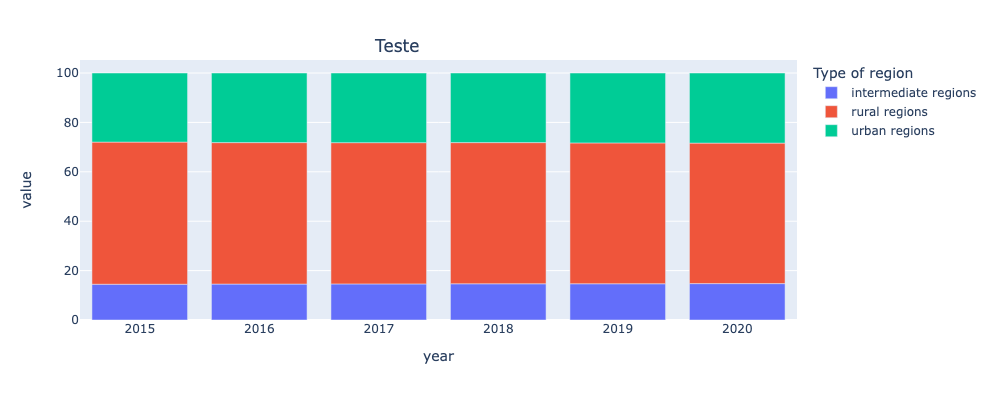

In [113]:
# Define our ColumnDataSource

source = ind_ie[ind_ie.code.isin(['CTX_SOC_01_2b','CTX_SOC_01_2a','CTX_SOC_01_2c'])]
    #.loc[:,['year','parameter','value']]

fig = px.bar(source, 
                 x="year", 
                 y="value", 
                 color="parameter", 
                 width=840, 
                 height=400)
fig.update_layout(
    title={
        'text': "Teste",
        'y':0.9,
        'x':0.4,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend_title="Type of region")
fig.show()


In [ ]:
ind_ie[ind_ie.code.isin(['CTX_SOC_01_2b','CTX_SOC_01_2a','CTX_SOC_01_2c'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 3622
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        18 non-null     object 
 1   subindicator     18 non-null     object 
 2   parameter        18 non-null     object 
 3   unit             18 non-null     object 
 4   code             18 non-null     object 
 5   source           18 non-null     object 
 6   memberStateCode  18 non-null     object 
 7   memberStateName  18 non-null     object 
 8   year             18 non-null     int64  
 9   value            18 non-null     float64
 10  flag             0 non-null      object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.7+ KB
